In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as mt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.metrics import roc_auc_score


In [2]:
curveList = [[103.9, 209.3], [316.6, 399.6], [425.3, 517.9], [590.5, 756.9], [1048.7, 1110.5], [1212.3, 1437.1]]
def generate_data(label):
    df_label = []
    f_1 = 'beginner_expert_processedData/'+label+'/'+label+'_'
    f_3 = '.csv'
    num_label = 19

    df_concat = pd.DataFrame()
    for curve_num in range(0,6):
        for idx in range(1, num_label+1):
            tmp_file = f_1+str(idx)+'_new2'+f_3
            df = pd.read_csv(tmp_file)
            df = df.dropna()
            tmp = df.astype(float)
            tmp['level'] =0

            tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]

            df_label.append(tmpcorner)
            df_concat = pd.concat([df_concat,df_label[idx-1]])

        df_label = []
        df_concat.to_csv('cornerData/corner1_'+str(curve_num+1)+'_'+label+'.csv')
        df_concat = pd.DataFrame()


In [3]:
def load_data(left_column,corner_number):
    if corner_number=='all':
        df_all = pd.DataFrame()
        for corner_number in range(1,7):
            df_tmp_begin = pd.read_csv('cornerData/corner_'+str(corner_number)+'_begin.csv')
            df_tmp_exp   = pd.read_csv('cornerData/corner_'+str(corner_number)+'_expert.csv')
            df_curve1 = pd.concat([df_tmp_begin, df_tmp_exp])
            df_all = pd.concat([df_all,df_curve1])
        df_curve1 = df_all
    else:
        df_tmp_begin = pd.read_csv('cornerData/corner_'+corner_number+'_begin.csv')
        df_tmp_exp   = pd.read_csv('cornerData/corner_'+corner_number+'_expert.csv')
        df_curve1 = pd.concat([df_tmp_begin, df_tmp_exp])

    df_curve1= df_curve1.loc[:,left_column]
    df_curve1_saved = df_curve1.loc[:,left_column]
    y = df_curve1.pop('level')
    X = df_curve1
    return X,y

In [4]:
def processing_data(X,y):
    y = np.array(y)
    X = np.array(X)
    print(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    sc = StandardScaler()
    sc.fit(X_train)

    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [5]:
def evaluate_model(X_train,X_test,y_train,y_test,kernel='rbf', C=1, gamma=0.01):
    svm_model = SVC(kernel=kernel, C=C, gamma=gamma)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    print(svm_model.score(X_train,y_train))
    print(svm_model.score(X_test,y_test))

    scoreSet = cross_val_score(svm_model, X_test, y_test, cv=5)
    print("\n\rUsing model_selection library    ")
    print("score set : ",end="")
    print(scoreSet)
    return y_test,y_pred

In [6]:
def confusion_matrix(y_test,y_pred):
    actual_result = y_test
    predicted_result = y_pred
    # 정확도
    accuracy = mt.accuracy_score(actual_result, predicted_result)
    # 오차행렬
    matrix = mt.confusion_matrix(actual_result, predicted_result)
    # 정밀도
    precision = mt.precision_score(actual_result, predicted_result)
    # 재현율
    recall = mt.recall_score(actual_result, predicted_result)
    # f1 score
    f1score = mt.f1_score(actual_result, predicted_result)
    # 전체보고서
    scores = mt.classification_report(actual_result, predicted_result)
    # 모두 출력
    print("정확도: ", accuracy, "\n")
    print("오차행렬\n", matrix, "\n")
    print("정밀도: ", precision, "\n")
    print("재현율: ", round(recall, 3), "\n")
    print("F1스코어: ", f1score, "\n")
    print("결과\n", scores)

In [7]:
def draw_ROC(y_test,y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Predicting a Pulsar Star classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()

    # compute ROC AUC
    ROC_AUC = roc_auc_score(y_test, y_pred)
    print('ROC AUC : {:.4f}'.format(ROC_AUC))

In [8]:
def grid_searching(X_train,y_train):
    svc=SVC() 
    # declare parameters for hyperparameter tuning
    parameters = [ {'C':[0.01,0.1,1, 10, 100], 'kernel':['linear']},
                   {'C':[0.01,0.1,1, 10, 100], 'kernel':['rbf'], 'gamma':[0.001,0.01,0.1, 0.3,0.4,0.5,0.6,0.8, 1,10]},
                   {'C':[0.01,0.1,1, 10, 100], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.1,1,10]} 
                  ]
    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'accuracy',
                               cv = 5,
                               verbose=0)
    grid_search.fit(X_train, y_train)
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
    # print estimator that was chosen by the GridSearch
    print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

In [9]:
all_column = [
#'Time',
#    'Distance',
    'GPS Latitude','GPS Longitude','Damper Velocity (Calc) FL','Damper Velocity (Calc) FR','Damper Velocity (Calc) RL',
'Damper Velocity (Calc) RR','Corr Dist','Corr Dist (Unstretched)','Corr Speed','Brake Pos',
'CG Accel Lateral','CG Accel Longitudinal','CG Accel Vertical','CG Height','Camber FL','Camber FR','Camber RL','Camber RR','Car Coord X',
'Car Coord Y','Car Coord Z','Car Pos Norm','Chassis Pitch Angle','Chassis Pitch Rate','Chassis Roll Angle','Chassis Roll Rate',
'Chassis Velocity X','Chassis Velocity Y','Chassis Velocity Z','Chassis Yaw Rate','Drive Train Speed','Engine RPM','Ground Speed',
'Ride Height FL','Ride Height FR','Ride Height RL','Ride Height RR','Road Temp','Self Align Torque FL','Self Align Torque FR',
'Self Align Torque RL','Self Align Torque RR','Session Time Left','Steering Angle','Suspension Travel FL','Suspension Travel FR',
'Suspension Travel RL','Suspension Travel RR','Tire Load FL','Tire Load FR','Tire Load RL','Tire Load RR','Tire Loaded Radius FL',
'Tire Loaded Radius FR','Tire Loaded Radius RL','Tire Loaded Radius RR','Tire Pressure FL','Tire Pressure FR','Tire Pressure RL','Tire Pressure RR',
'Tire Rubber Grip FL','Tire Rubber Grip FR','Tire Rubber Grip RL','Tire Rubber Grip RR','Tire Slip Angle FL','Tire Slip Angle FR',
'Tire Slip Angle RL','Tire Slip Angle RR','Tire Slip Ratio FL','Tire Slip Ratio FR','Tire Slip Ratio RL','Tire Slip Ratio RR',
'Tire Temp Core FL','Tire Temp Core FR','Tire Temp Core RL','Tire Temp Core RR','Tire Temp Inner FL','Tire Temp Inner FR',
'Tire Temp Inner RL','Tire Temp Inner RR','Tire Temp Middle FL','Tire Temp Middle FR','Tire Temp Middle RL',
'Tire Temp Middle RR','Tire Temp Outer FL','Tire Temp Outer FR','Tire Temp Outer RL','Tire Temp Outer RR','Toe In FL',
'Toe In FR','Toe In RL','Toe In RR','Wheel Angular Speed FL','Wheel Angular Speed FR','Wheel Angular Speed RL','Wheel Angular Speed RR',
'CG Distance','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration','level']

selected_column = ['Brake Pos', 'Ground Speed', 'Steering Angle', 'Throttle Pos', 'Chassis Yaw Rate', 'Chassis Velocity X',
                   'Chassis Velocity Y','Chassis Velocity Z','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration',
                   'CG Distance','level']

def run_experiment(column, corner):
    X,y = load_data(column,corner)
    X_train, X_test, y_train, y_test = processing_data(X,y)
    y_test,y_pred = evaluate_model(X_train, X_test, y_train, y_test,'linear',1,0.01)
    confusion_matrix(y_test,y_pred)
    draw_ROC(y_test,y_pred)

def finding_hyperparameter(column,corner):
    X,y = load_data(column,corner)
    X_train, X_test, y_train, y_test = processing_data(X,y)
    grid_searching(X_train,y_train)

******************************all*****************************
************1***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [1.         0.98214286 0.98214286 1.         0.99099099]
정확도:  1.0 

오차행렬
 [[304   0]
 [  0 255]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       304
           1       1.00      1.00      1.00       255

    accuracy                           1.00       559
   macro avg       1.00      1.00      1.00       559
weighted avg       1.00      1.00      1.00       559



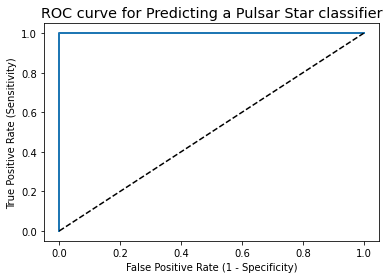

ROC AUC : 1.0000
************2***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [0.96103896 0.98701299 0.98701299 0.98701299 0.98701299]
정확도:  1.0 

오차행렬
 [[207   0]
 [  0 178]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       207
           1       1.00      1.00      1.00       178

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385



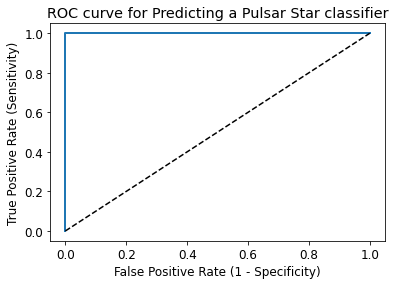

ROC AUC : 1.0000
************3***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [1.         0.97983871 1.         1.         0.99596774]
정확도:  1.0 

오차행렬
 [[957   0]
 [  0 283]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       283

    accuracy                           1.00      1240
   macro avg       1.00      1.00      1.00      1240
weighted avg       1.00      1.00      1.00      1240



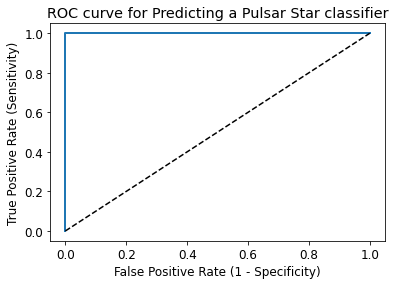

ROC AUC : 1.0000
************4***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [1.         0.98611111 0.99305556 0.97916667 1.        ]
정확도:  1.0 

오차행렬
 [[403   0]
 [  0 316]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       403
           1       1.00      1.00      1.00       316

    accuracy                           1.00       719
   macro avg       1.00      1.00      1.00       719
weighted avg       1.00      1.00      1.00       719



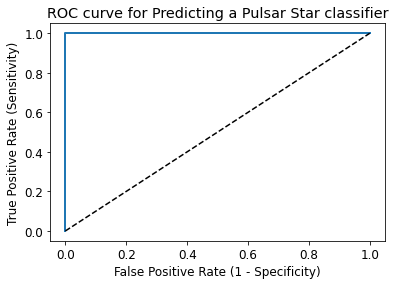

ROC AUC : 1.0000
************5***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [1. 1. 1. 1. 1.]
정확도:  1.0 

오차행렬
 [[118   0]
 [  0  97]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        97

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



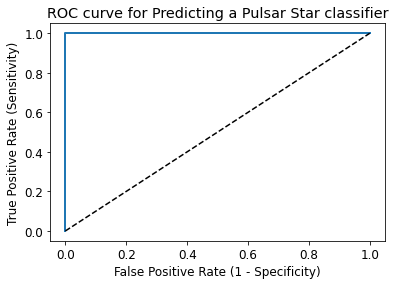

ROC AUC : 1.0000
************6***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [0.9954955 1.        1.        0.9954955 1.       ]
정확도:  1.0 

오차행렬
 [[629   0]
 [  0 480]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       629
           1       1.00      1.00      1.00       480

    accuracy                           1.00      1109
   macro avg       1.00      1.00      1.00      1109
weighted avg       1.00      1.00      1.00      1109



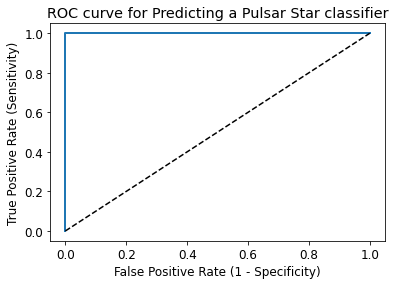

ROC AUC : 1.0000
************all***************
[0 0 0 ... 1 1 1]
1.0
1.0

Using model_selection library    
score set : [0.99881657 1.         1.         0.99881657 1.        ]
정확도:  1.0 

오차행렬
 [[2616    0]
 [   0 1608]] 

정밀도:  1.0 

재현율:  1.0 

F1스코어:  1.0 

결과
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2616
           1       1.00      1.00      1.00      1608

    accuracy                           1.00      4224
   macro avg       1.00      1.00      1.00      4224
weighted avg       1.00      1.00      1.00      4224



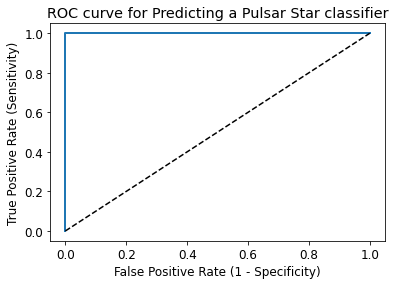

ROC AUC : 1.0000
******************************select*****************************
************1***************
[0 0 0 ... 1 1 1]
0.8051948051948052
0.815742397137746

Using model_selection library    
score set : [0.79464286 0.75       0.8125     0.77678571 0.83783784]
정확도:  0.815742397137746 

오차행렬
 [[236  68]
 [ 35 220]] 

정밀도:  0.7638888888888888 

재현율:  0.863 

F1스코어:  0.8103130755064457 

결과
               precision    recall  f1-score   support

           0       0.87      0.78      0.82       304
           1       0.76      0.86      0.81       255

    accuracy                           0.82       559
   macro avg       0.82      0.82      0.82       559
weighted avg       0.82      0.82      0.82       559



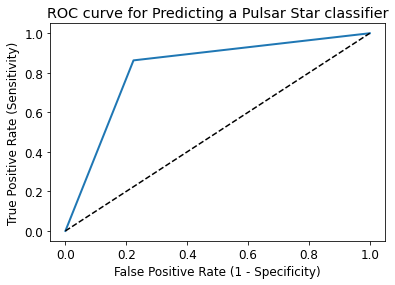

ROC AUC : 0.8195
************2***************
[0 0 0 ... 1 1 1]
0.845703125
0.8415584415584415

Using model_selection library    
score set : [0.87012987 0.87012987 0.8961039  0.83116883 0.84415584]
정확도:  0.8415584415584415 

오차행렬
 [[176  31]
 [ 30 148]] 

정밀도:  0.8268156424581006 

재현율:  0.831 

F1스코어:  0.8291316526610645 

결과
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       207
           1       0.83      0.83      0.83       178

    accuracy                           0.84       385
   macro avg       0.84      0.84      0.84       385
weighted avg       0.84      0.84      0.84       385



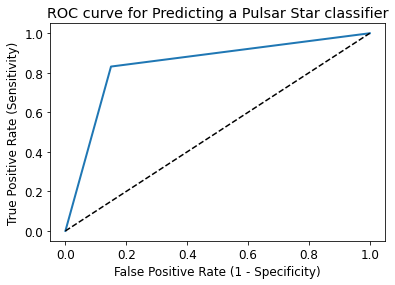

ROC AUC : 0.8409
************3***************
[0 0 0 ... 1 1 1]
0.91545601291364
0.9314516129032258

Using model_selection library    
score set : [0.92741935 0.94354839 0.93145161 0.93951613 0.91532258]
정확도:  0.9314516129032258 

오차행렬
 [[907  50]
 [ 35 248]] 

정밀도:  0.8322147651006712 

재현율:  0.876 

F1스코어:  0.8537005163511188 

결과
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       957
           1       0.83      0.88      0.85       283

    accuracy                           0.93      1240
   macro avg       0.90      0.91      0.90      1240
weighted avg       0.93      0.93      0.93      1240



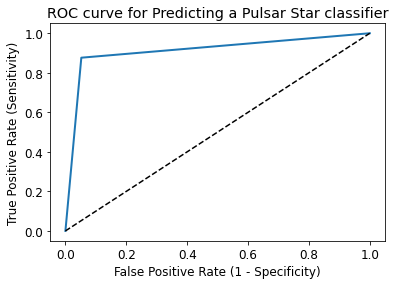

ROC AUC : 0.9120
************4***************
[0 0 0 ... 1 1 1]
0.8517229376957883
0.8567454798331016

Using model_selection library    
score set : [0.89583333 0.86111111 0.88194444 0.84027778 0.81818182]
정확도:  0.8567454798331016 

오차행렬
 [[342  61]
 [ 42 274]] 

정밀도:  0.817910447761194 

재현율:  0.867 

F1스코어:  0.8417818740399385 

결과
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       403
           1       0.82      0.87      0.84       316

    accuracy                           0.86       719
   macro avg       0.85      0.86      0.86       719
weighted avg       0.86      0.86      0.86       719



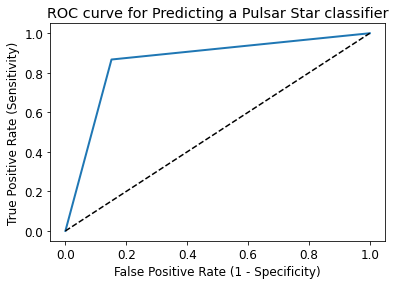

ROC AUC : 0.8579
************5***************
[0 0 0 ... 1 1 1]
0.9463869463869464
0.9488372093023256

Using model_selection library    
score set : [1.         0.90697674 0.95348837 0.88372093 0.90697674]
정확도:  0.9488372093023256 

오차행렬
 [[111   7]
 [  4  93]] 

정밀도:  0.93 

재현율:  0.959 

F1스코어:  0.9441624365482233 

결과
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       118
           1       0.93      0.96      0.94        97

    accuracy                           0.95       215
   macro avg       0.95      0.95      0.95       215
weighted avg       0.95      0.95      0.95       215



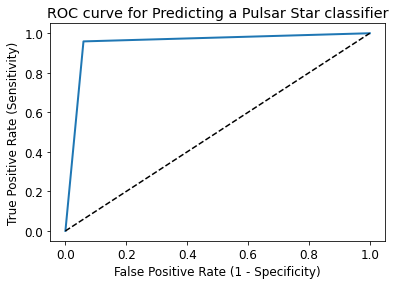

ROC AUC : 0.9497
************6***************
[0 0 0 ... 1 1 1]
0.711837655016911
0.7069431920649234

Using model_selection library    
score set : [0.74774775 0.66666667 0.68918919 0.67117117 0.70135747]
정확도:  0.7069431920649234 

오차행렬
 [[438 191]
 [134 346]] 

정밀도:  0.6443202979515829 

재현율:  0.721 

F1스코어:  0.6804326450344149 

결과
               precision    recall  f1-score   support

           0       0.77      0.70      0.73       629
           1       0.64      0.72      0.68       480

    accuracy                           0.71      1109
   macro avg       0.71      0.71      0.70      1109
weighted avg       0.71      0.71      0.71      1109



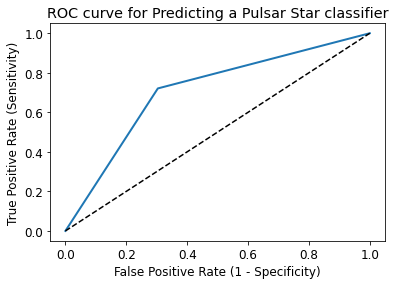

ROC AUC : 0.7086
************all***************
[0 0 0 ... 1 1 1]
0.7228009944358944
0.7161458333333334

Using model_selection library    
score set : [0.70059172 0.6887574  0.71597633 0.71360947 0.72867299]
정확도:  0.7161458333333334 

오차행렬
 [[2052  564]
 [ 635  973]] 

정밀도:  0.6330513988288874 

재현율:  0.605 

F1스코어:  0.6187599364069951 

결과
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      2616
           1       0.63      0.61      0.62      1608

    accuracy                           0.72      4224
   macro avg       0.70      0.69      0.70      4224
weighted avg       0.71      0.72      0.71      4224



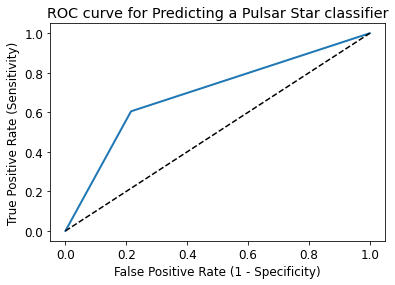

ROC AUC : 0.6948


In [10]:
###for loop for all experiments 
columns = {'all':all_column, 'select':selected_column}
corners = ['1','2','3','4','5','6','all']

for key,value in columns.items():
    print('******************************'+key+'*****************************')
    for corner in corners:
        print('************'+corner+'***************')
        run_experiment(value, corner)

In [11]:
finding_hyperparameter(selected_column, 'all')

[0 0 0 ... 1 1 1]


KeyboardInterrupt: 

In [ ]:
GridSearch CV best score : 0.9203


Parameters that give the best results : 

 {'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=10, gamma=0.3)


finding_hyperparameter(selected_column, '2')
GridSearch CV best score : 0.9147
Parameters that give the best results : 

 {'C': 10, 'gamma': 0.4, 'kernel': 'rbf'}
Estimator that was chosen by the search : 

 SVC(C=10, gamma=0.4)